# 1. The Huber Loss [15 pts]

In statistics, we frequently encounter data sets containing outliers, which are bad data points arising from experimental error or abnormally high noise. Consider for example the following data set consisting of 15 pairs $(x, y)$.

| $x$ | 1    | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 | 12 | 13 | 14 | 15 |
|-----|------|------|------|------|------|------|------|------|------|------|------|------|------|------|------|
| $y$ | 6.31 | 3.78 | 28.0 | 1.71 | 2.99 | 4.53 | 2.11 | 3.88 | 4.67 | 4.25 | 2.06 | 23.0 | 1.58 | 2.17 | 0.02 |

The $y$ values corresponding to $x = 3$ and $x = 12$ are *outliers* because they are far outside the expected range of values for the experiment.

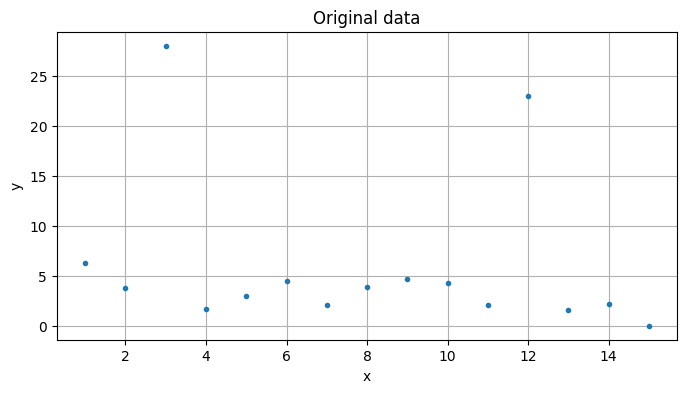

In [1]:
x = [1:15;]
y = [6.31, 3.78, 28.0, 1.71, 2.99, 4.53, 2.11, 3.88, 4.67, 4.25, 2.06, 23.0, 1.58, 2.17, 0.02]

using PyPlot

figure(figsize=(8,4))
title("Original data")
plot(x, y, ".")
xlabel("x")
ylabel("y")
grid("on")

__a)__ Compute the best linear fit to the data using an $l_2$ cost (least squares). In other words, we are looking for the $a$ and $b$ that minimize the expression:

<img src="1l2.png">

Repeat the linear fit computation but this time exclude the outliers from your data set. On a single plot, show the data points and both linear fits. Explain the difference between both fits.

In [2]:
# without removing outliers, using l_2

# order of polynomial to use
k = 1

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

using JuMP, Gurobi, Mosek

m = Model(solver=MosekSolver(LOG=0))

@variable(m, u[1:k+1])
@objective(m, Min, sum( (y - A*u).^2 ) )
status = solve(m)
uopt = getvalue(u)
println(status)
println(uopt)

Optimal
[-0.362214,8.96838]


In [3]:
# with removed outliers using l_2
x1 = [1:13;]
y1 = [6.31, 3.78, 1.71, 2.99, 4.53, 2.11, 3.88, 4.67, 4.25, 2.06, 1.58, 2.17, 0.02]

# order of polynomial to use
k = 1

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n1 = length(x1)
A1 = zeros(n1,k+1)
for i = 1:n1
    for j = 1:k+1
        A1[i,j] = x1[i]^(k+1-j)
    end
end

using JuMP, Gurobi, Mosek

m1 = Model(solver=MosekSolver(LOG=0))

@variable(m1, u1[1:k+1])
@objective(m1, Min, sum( (y1 - A1*u1).^2 ) )
status1 = solve(m1)
uopt1 = getvalue(u1)
println(status1)
println(uopt1)

Optimal
[-0.258791,4.89308]


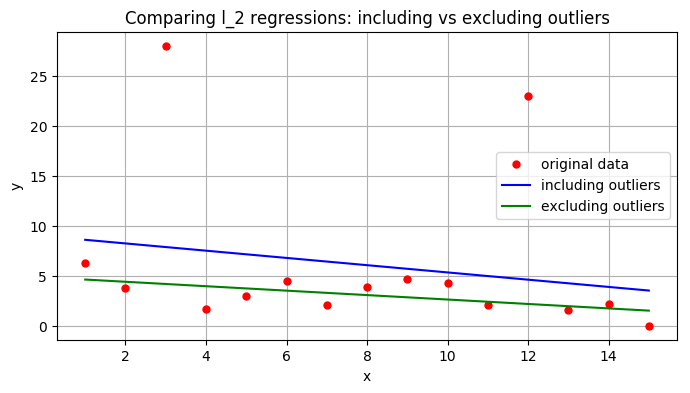

In [4]:
using PyPlot

npts = 100
xfine = linspace(x[1], x[end], npts)
xfine1 = linspace(x1[1], x1[end], npts)
ffine = ones(npts)
ffine1 = ones(npts)

for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
    ffine1 = [ffine1.*xfine1 ones(npts)]
end
yfine = ffine * uopt
yfine1 = ffine1 * uopt1

figure(figsize=(8,4))
title("Comparing l_2 regressions: including vs excluding outliers")
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
plot( xfine, yfine1, "g-")
legend(["original data", "including outliers", "excluding outliers"], loc="right")
xlabel("x")
ylabel("y")
grid()
;

The outliers included in the first regression line essentially shifted the true regression line upwards. We notice a slight change of the gradient too, but for this data set, the effect could be considered negligible. 

In the second regression line, we see that the line touches some of the plotted data, making it a btter line of best fit, because it minimizes the error in $y$ at each $x$

__b)__  It’s not always practical to remove outliers from the data manually, so we’ll investigate ways of automatically dealing with outliers by changing our cost function. Find the best linear fit again (including the outliers), but this time use the $l_1$ cost function:

<img src="1l1.png">

Include a plot containing the data and the best $l_1$ linear fit. Does the $l_1$ cost handle outliers better or worse than least squares? Explain why.

In [5]:
using JuMP, Gurobi

import JuMP: GenericAffExpr

function abs_array{V<:GenericAffExpr}(v::Array{V})
 m = first(first(v).vars).m
 @variable(m, aux[1:length(v)] >= 0)
 @constraint(m, aux .>= v)
 @constraint(m, aux .>= -v)
 return aux
end;

In [6]:
# order of polynomial to use
k = 1

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n2 = length(x)
A2 = zeros(n2,k+1)
for i = 1:n2
    for j = 1:k+1
        A2[i,j] = x[i]^(k+1-j)
    end
end

using JuMP, Gurobi, Mosek

m2 = Model(solver=MosekSolver(LOG=0))
@variable(m2, u2[1:k+1])
#@variable(m2, t)
#@constraint(m2, -t <= y - A2*u2 <= t)
#@objective(m, Min, t)

@objective(m2, Min, sum( abs_array(y - A2*u2) ) )

status2 = solve(m2)
uopt2 = getvalue(u2)
println(status)
println(uopt2)

Optimal
[-0.356,6.666]


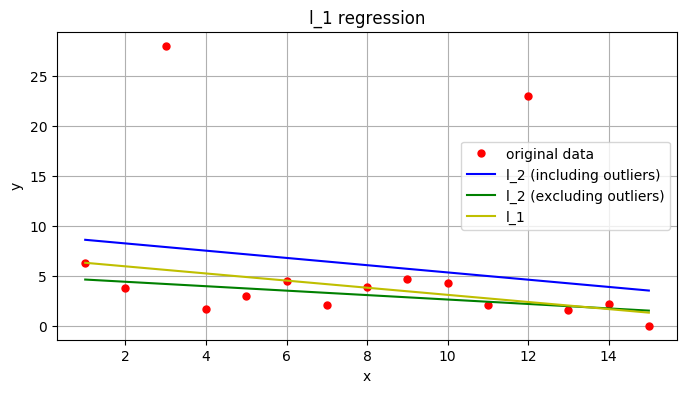

In [7]:
using PyPlot

npts = 100
xfine2 = linspace(x[1], x[end], npts)
ffine2 = ones(npts)

for j = 1:k
    ffine2 = [ffine2.*xfine2 ones(npts)]
end
yfine2 = ffine2 * uopt2

figure(figsize=(8,4))
title("l_1 regression")
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
plot( xfine, yfine1, "g-")
plot( xfine2, yfine2, "y-")
legend(["original data", "l_2 (including outliers)", "l_2 (excluding outliers)", "l_1"], loc="right")
xlabel("x")
ylabel("y")
grid()
;

In [8]:
println("error in m1 (l_2): ", getobjectivevalue(m1))
println("error in m2 (l_1): ", getobjectivevalue(m2))

error in m1 (l_2): 21.681303296703305
error in m2 (l_1): 58.03000000020826


l_2 handles the line of best fit better, simply because the data isn't distorted *at all* by the outliers, whereas l_1 still faces some of the distortion due to them. 

__c)__ Another approach is to use an $l_2$ penalty for points that are close to the line but an $l_1$ penalty for points that are far away. Specifically, we’ll use something called the Huber loss, defined as:

<img src="1phi.png">

Here, $M$ is a parameter that determines where the quadratic function transitions to a linear function. The plot below shows what the Huber loss function looks like for $M = 1$.

<img src="1c.png">

The formula above is simple, but not in a form that is useful for us. As it turns out, we can evaluate the Huber loss function at any point $x$ by solving the following convex QP instead:

<img src="1phi2.png">

Verify this fact by solving the above QP (with $M = 1$) for many values of $x$ in the interval $−3 ≤ x ≤ 3$ and reproducing the plot above. Finally, find the best linear fit to our data using a Huber loss with $M = 1$ and produce a plot showing your fit. The cost function is:

<img src="1d.png">

In [9]:
using JuMP, PyPlot, Mosek

function getY(x, M)

    m3 = Model(solver=MosekSolver(LOG=0))

    @variable(m3, v >= 0)
    @variable(m3, w <= M)

    @constraint(m3, abs(x) <= w + v)

    @objective(m3, Min, w^2 + 2*M*v)

    solve(m3)

    return getobjectivevalue(m3)
end;

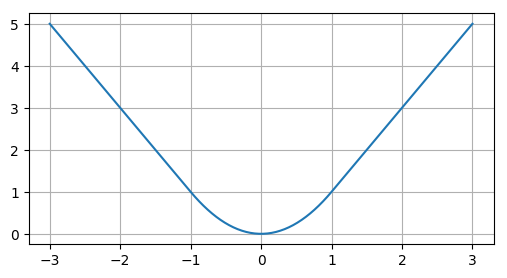

In [10]:
M = 1
x_h = linspace(-3, 3, 100)

y_h = zeros(length(x_h))
for i = 1:length(x_h)
    y_h[i] = getY(x_h[i], M)
end

figure(figsize=(6,3))
plot(x_h,y_h)
grid();

In [11]:
# order of polynomial to use
k = 1

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n4 = length(x)
A4 = zeros(n4,k+1)
for i = 1:n4
    for j = 1:k+1
        A4[i,j] = x[i]^(k+1-j)
    end
end

using JuMP, Gurobi, Mosek

m4 = Model(solver=MosekSolver(LOG=0))

M = 1
@variable(m4, u4[1:k+1])
@variable(m4, v[1:n4] >= 0)
@variable(m4, w[1:n4] <= M)

@constraint(m4, abs_array(y - A4*u4) .<= w + v)

@objective(m4, Min, sum(w[i]^2 + 2*M*v[i] for i in 1:n4))

status4 = solve(m4)
uopt4 = getvalue(u4)
println(status4)
println(uopt4)

Optimal
[-0.281108,5.73812]


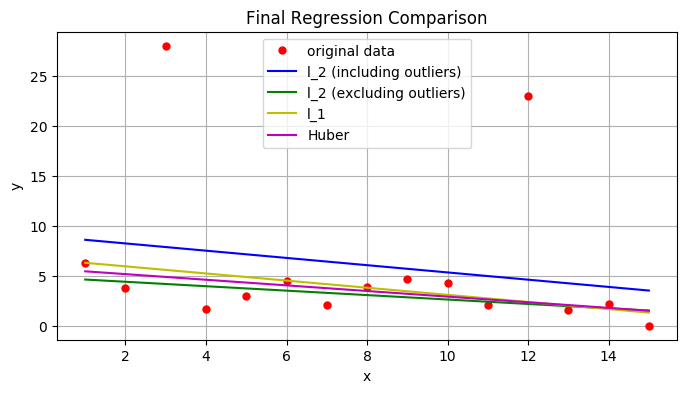

In [13]:
figure(figsize=(8,4))
title("Final Regression Comparison")
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
plot( xfine, yfine1, "g-")
plot( xfine2, yfine2, "y-")
plot( x, A*uopt4, "m-")
legend(["original data", "l_2 (including outliers)", "l_2 (excluding outliers)", "l_1", "Huber"], loc="top")
xlabel("x")
ylabel("y")
grid()